In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option("display.max_columns", None)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [70]:
train = pd.read_csv("C:\\scnguh\\datamining\\pubg\\all\\train_V2.csv")
test = pd.read_csv("C:\\scnguh\\datamining\\pubg\\all\\test_V2.csv")

In [71]:
# killPlace
train = train[train.killPlace <= 100]
# winPlacePerc should not be null
train = train[train.winPlacePerc >= 0 ]

In [72]:
df_all = pd.concat([train, test])

In [73]:
## Feature project, part1 Personal features

# DBNOs ratio in whole team
df1 = df_all.groupby(['groupId'], as_index=False).agg({'DBNOs':'sum'})
df1.reset_index(inplace=True, drop=True)
df1.rename(columns={'DBNOs':'DBNOs_team'}, inplace=True)
df2 = pd.merge(df_all, df1, on='groupId', how='left')
df2 = df2[['Id', 'DBNOs', 'DBNOs_team']]
df2.loc[:, 'DBNOs_ratio'] = df2.DBNOs / df2.DBNOs_team
feature1 = df2[['Id', 'DBNOs_ratio']]
feature1.fillna(0, inplace=True)

In [74]:
# Assists ratio in whole team
df1 = df_all.groupby(['groupId'], as_index=False).agg({'assists':'sum'})
df1.reset_index(inplace=True, drop=True)
df1.rename(columns={'assists':'assists_team'}, inplace=True)
df2 = pd.merge(df_all, df1, on='groupId', how='left')
df2 = df2[['Id', 'assists', 'assists_team']]
df2.loc[:, 'assists_ratio'] = df2.assists / df2.assists_team
feature2 = df2[['Id', 'assists_ratio']]
feature2.fillna(0, inplace=True)

In [75]:
# Damage ratio in whole team
df1 = df_all.groupby(['groupId'], as_index=False).agg({'damageDealt':'sum'})
df1.reset_index(inplace=True, drop=True)
df1.rename(columns={'damageDealt':'damageDealt_team'}, inplace=True)
df2 = pd.merge(df_all, df1, on='groupId', how='left')
df2 = df2[['Id', 'damageDealt', 'damageDealt_team']]
df2.loc[:, 'damageDealt_ratio'] = df2.damageDealt / df2.damageDealt_team
feature3 = df2[['Id', 'damageDealt_ratio']]
feature3.fillna(0, inplace=True)

In [76]:
# Headshot ratio
df1 = df_all[['Id', 'headshotKills', 'kills']]
df1.loc[:,'headshot_ratio'] = df1.headshotKills / df1.kills
feature4 = df1[['Id', 'headshot_ratio']]
feature4.fillna(0, inplace=True)

In [77]:
# Heals ratio in whole team
df1 = df_all.groupby(['groupId'], as_index=False).agg({'heals':'sum'})
df1.reset_index(inplace=True, drop=True)
df1.rename(columns={'heals':'heals_team'}, inplace=True)
df2 = pd.merge(df_all, df1, on='groupId', how='left')
df2 = df2[['Id', 'heals', 'heals_team']]
df2.loc[:, 'heals_ratio'] = df2.heals / df2.heals_team
feature5 = df2[['Id', 'heals_ratio']]
feature5.fillna(0, inplace=True)

In [78]:
# Rank delta
df1 = df_all[['Id', 'killPlace', 'maxPlace']]
df1.loc[:,'rank_delta'] = abs(df1.killPlace - df1.maxPlace)
feature6 = df1[['Id', 'rank_delta']]

In [79]:
# Is kill place top 10
df1 = df_all[['Id', 'killPlace']]
df2 = df1[df1.killPlace <= 10]
df3 = df1[df1.killPlace > 10]
df2.loc[:,'is_killplace_top10'] = 1
df3.loc[:,'is_killplace_top10'] = 0
df4 = pd.concat([df2, df3])
feature7 = df4[['Id', 'is_killplace_top10']]

In [80]:
# Total moving distance
df1 = df_all[['Id', 'rideDistance', 'swimDistance', 'walkDistance', 'winPlacePerc']]
df1.loc[:,'total_distance'] = df1.rideDistance + df1.swimDistance + df1.walkDistance
'''
low: [0, 0.3]              L
medium: (0.3, 0.6]         M
medium high: (0.6, 0.85]   MH
high: (0.85, 1]            H

level  mean_distance
0     H     4097.159395
1     L      230.670046
2     M     1338.473811
3    MH     3118.616026
'''
# temp.loc[:,'level'] = temp.apply(lambda x:'L' if x[1]>=0 and x[1]<=0.3 \
#                                  else ('M' if x[1]>0.3 and x[1]<=0.6 \
#                                        else ('MH' if x[1]>0.6 and x[1]<=0.85 \
#                                              else 'H')), axis=1)
bins = [0, 230, 1338, 3118, 4097, float("inf")]
labels = ['A', 'B', 'C', 'D', 'E']
temp1 = pd.cut(df1.total_distance, bins, labels=labels, include_lowest=True)
feature8 = pd.concat([df1[['Id']], temp1], axis=1)

In [81]:
# Merge personal features
features = [feature1, feature2, feature3, feature4, feature5, feature6, feature7, feature8]
person_features = df_all.Id.to_frame()
for ft in features:
    person_features = pd.merge(person_features, ft, on='Id')

In [82]:
## Group features

# Teammates
df1 = df_all[['groupId', 'matchId']]
df2 = df1.groupby(['groupId'], as_index=False).agg({'matchId':'count'})
df2.rename(columns={'matchId':'teammates'}, inplace=True)
gf1 = df2

In [83]:
# Group avg damage
df1 = df_all[['groupId', 'damageDealt']]
df2 = df1.groupby(['groupId'], as_index=False).agg({'damageDealt':'sum'})
df2.rename(columns={'damageDealt':'gp_damage'}, inplace=True)
df3 = pd.merge(df2, gf1, on='groupId')
df3.loc[:,'gp_avg_damage'] = df3.gp_damage / df3.teammates
gf2 = df3[['groupId', 'gp_avg_damage']]

In [84]:
# Group avg knock down
df1 = df_all[['groupId', 'DBNOs']]
df2 = df1.groupby(['groupId'], as_index=False).agg({'DBNOs':'sum'})
df2.rename(columns={'DBNOs':'gp_DBNOs'}, inplace=True)
df3 = pd.merge(df2, gf1, on='groupId')
df3.loc[:,'gp_avg_DBNOs'] = df3.gp_DBNOs / df3.teammates
gf3 = df3[['groupId', 'gp_avg_DBNOs']]

In [85]:
# Group avg kills
df1 = df_all[['groupId', 'kills']]
df2 = df1.groupby(['groupId'], as_index=False).agg({'kills':'sum'})
df2.rename(columns={'kills':'gp_kills'}, inplace=True)
df3 = pd.merge(df2, gf1, on='groupId')
df3.loc[:,'gp_avg_kills'] = df3.gp_kills / df3.teammates
gf4 = df3[['groupId', 'gp_avg_kills']]

In [86]:
# Group avg ride distance
df1 = df_all[['groupId', 'rideDistance']]
df2 = df1.groupby(['groupId'], as_index=False).agg({'rideDistance':'sum'})
df2.rename(columns={'rideDistance':'gp_rideDistance'}, inplace=True)
df3 = pd.merge(df2, gf1, on='groupId')
df3.loc[:,'gp_avg_rideDistance'] = df3.gp_rideDistance / df3.teammates
gf5 = df3[['groupId', 'gp_avg_rideDistance']]
df_all.drop(['rideDistance', 'swimDistance', 'walkDistance'], axis=1, inplace=True)

In [87]:
# Group top kill place
df1 = df_all[['groupId', 'killPlace']]
df2 = df1.groupby(['groupId'], as_index=False).agg({'killPlace':'min'})
df2.rename(columns={'killPlace':'gp_top_killPlace'}, inplace=True)
bins = [0, 10, 30, 50, float("inf")]
labels = ["A", "B", "C", "D"]
out = pd.cut(df2.gp_top_killPlace, bins, labels=labels, include_lowest=True)
df2.rename(columns={'gp_top_killPlace':'gp_top_killPlace1'}, inplace=True)
gf6 = pd.concat([df2, out], axis=1)
gf6.drop(['gp_top_killPlace1'], axis=1, inplace=True)

In [88]:
# Group highest kills
df1 = df_all[['groupId', 'kills']]
df2 = df1.groupby(['groupId'], as_index=False).agg({'kills':'max'})
df2.rename(columns={'kills':'gp_highest_kill'}, inplace=True)
bins = [0, 5, 10, 15, float("inf")]
labels = ["A", "B", "C", "D"]
out = pd.cut(df2.gp_highest_kill, bins, labels=labels, include_lowest=True)
df2.rename(columns={'gp_highest_kill':'gp_highest_kill1'}, inplace=True)
gf7 = pd.concat([df2, out], axis=1)
gf7.drop(['gp_highest_kill1'], axis=1, inplace=True)

In [89]:
# Group lowest kills
df1 = df_all[['groupId', 'kills']]
df2 = df1.groupby(['groupId'], as_index=False).agg({'kills':'min'})
df2.rename(columns={'kills':'gp_lowest_kill'}, inplace=True)
bins = [0, 5, 10, 15, float("inf")]
labels = ["A", "B", "C", "D"]
out = pd.cut(df2.gp_lowest_kill, bins, labels=labels, include_lowest=True)
df2.rename(columns={'gp_lowest_kill':'gp_lowest_kill1'}, inplace=True)
gf8 = pd.concat([df2, out], axis=1)
gf8.drop(['gp_lowest_kill1'], axis=1, inplace=True)

In [90]:
# Group headshot ratio
df1 = df_all[['groupId', 'headshotKills', 'kills']]
df2 = df1.groupby(['groupId'], as_index=False).agg({'headshotKills':'sum', 'kills':'sum'})
df2.loc[:,'headshot_ratio'] = df2.headshotKills / df2.kills
df2.fillna(0, inplace=True)
df2.drop(['headshotKills', 'kills'], axis=1, inplace=True)
gf9 = df2

In [91]:
# Merge group features
features = [gf1, gf2, gf3, gf4, gf5, gf6, gf7, gf8, gf9]
group_features = df_all.groupId.to_frame()
group_features.drop_duplicates(inplace=True)
for ft in features:
    group_features = pd.merge(group_features, ft, on='groupId')

In [92]:
## Processing original data
# [1]
bins = [0, 500, 800, 1000, 1500, 2000, float("inf")]
labels = ["A", "B", "C", "D", "E", "F"]
out = pd.cut(df_all.damageDealt, bins, labels=labels, include_lowest=True)
df_all.rename(columns={'damageDealt':'damageDealt1'}, inplace=True)
df_all = pd.concat([df_all, out], axis=1)
df_all.drop(['damageDealt1'], axis=1, inplace=True)

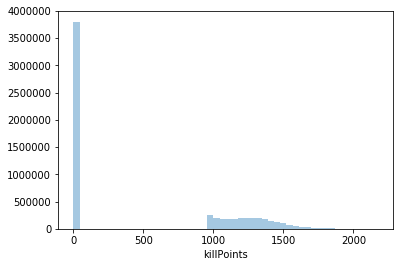

In [93]:
# [2]
sns.distplot(df_all.killPoints, kde=False)
plt.show()

bins = [0, 200, 500, 1000, 1500, 1800, 2000, float("inf")]
labels = ["A", "B", "C", "D", "E", "F", "G"]
out = pd.cut(df_all.killPoints, bins, labels=labels, include_lowest=True)
df_all.rename(columns={'killPoints':'killPoints1'}, inplace=True)
df_all = pd.concat([df_all, out], axis=1)
df_all.drop(['killPoints1'], axis=1, inplace=True)

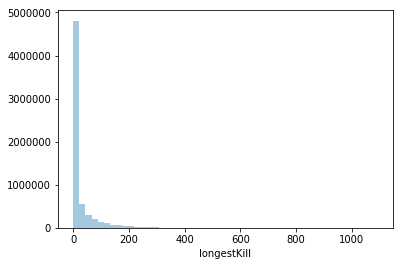

In [94]:
# [3]
sns.distplot(df_all.longestKill, kde=False)
plt.show()
bins = [0, 200, 500, 800, 1000, float("inf")]
labels = ["A", "B", "C", "D", "E"]
out = pd.cut(df_all.longestKill, bins, labels=labels, include_lowest=True)
df_all.rename(columns={'longestKill':'longestKill1'}, inplace=True)
df_all = pd.concat([df_all, out], axis=1)
df_all.drop(['longestKill1'], axis=1, inplace=True)


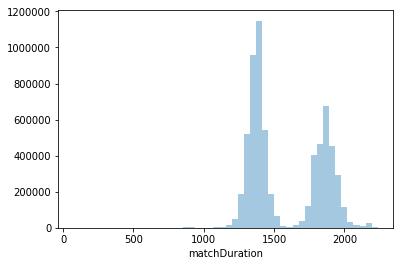

In [95]:
# [4]
sns.distplot(df_all.matchDuration, kde=False)
plt.show()
bins = [0, 1000, 1500, 2000, float("inf")]
labels = ["A", "B", "C", "D"]
out = pd.cut(df_all.matchDuration, bins, labels=labels, include_lowest=True)
df_all.rename(columns={'matchDuration':'matchDuration1'}, inplace=True)
df_all = pd.concat([df_all, out], axis=1)
df_all.drop(['matchDuration1'], axis=1, inplace=True)

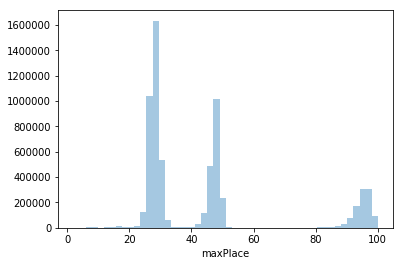

In [96]:
# [5]
sns.distplot(df_all.maxPlace, kde=False)
plt.show()
bins = [0, 10, 30, 50, float("inf")]
labels = ["A", "B", "C", "D"]
out = pd.cut(df_all.maxPlace, bins, labels=labels, include_lowest=True)
df_all.rename(columns={'maxPlace':'maxPlace1'}, inplace=True)
df_all = pd.concat([df_all, out], axis=1)
df_all.drop(['maxPlace1'], axis=1, inplace=True)

In [97]:
# [6]
bins = [0, 25, 50, 100]
labels = ["A", "B", "C"]
out = pd.cut(df_all.numGroups, bins, labels=labels, include_lowest=True)
df_all.rename(columns={'numGroups':'numGroups1'}, inplace=True)
df_all = pd.concat([df_all, out], axis=1)
df_all.drop(['numGroups1'], axis=1, inplace=True)

In [98]:
# [7]
bins = [-1, 0, 1000, 2000, 3000, 4000, 5000, float("inf")]
labels = ["N", "A", "B", "C", "D", "E", "F"]
out = pd.cut(df_all.rankPoints, bins, labels=labels, include_lowest=True)
df_all.rename(columns={'rankPoints':'rankPoints1'}, inplace=True)
df_all = pd.concat([df_all, out], axis=1)
df_all.drop(['rankPoints1'], axis=1, inplace=True)

In [99]:
## Merge person features to original data
df = pd.merge(df_all, person_features, on='Id')

## Merge group features to original data
df = pd.merge(df, group_features, on='groupId')

test_id = df[-len(test):].Id.values
df.drop(['Id', 'groupId', 'matchId'], 1, inplace=True)

for index, value in df.dtypes.iteritems():
    if str(value) in ['object', 'category']:
        # One-hot encode for character feature
        dummy_features = pd.get_dummies(df[index], prefix=index)
        for dummy in dummy_features:
            df[dummy] = dummy_features[dummy]
        df.drop([index], 1, inplace=True)
        
yTrain = np.array(train.winPlacePerc)

# Normalize numberic value
for index, value in df.dtypes.iteritems():
    minValue = df[index].min()
    maxValue = df[index].max()
    df[index] = df[index].apply(lambda x:(x - minValue) / (maxValue - minValue) if maxValue != minValue else 0)    

In [100]:
# Split train/test
train = df[:-len(test)]
test = df[-len(test):] 

In [101]:
# Modeling:xgboost
train.drop(['winPlacePerc'], 1, inplace=True)
test.drop(['winPlacePerc'], 1, inplace=True)

num_trees = 300
params = {"objective": "reg:linear",
          "eta": 0.15,
          "max_depth": 12,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1,
          "nthread": 2
          }

dtrain = xgb.DMatrix(train, label=yTrain)
dtest = xgb.DMatrix(test)
watchlist = [(dtrain, 'train')]

gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, verbose_eval=True)

yhat = gbm.predict(dtest)

[0]	train-rmse:0.308208
Will train until train-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.307932
[2]	train-rmse:0.307722
[3]	train-rmse:0.307547
[4]	train-rmse:0.307377
[5]	train-rmse:0.307272
[6]	train-rmse:0.307162
[7]	train-rmse:0.307098
[8]	train-rmse:0.30704
[9]	train-rmse:0.306976
[10]	train-rmse:0.306884
[11]	train-rmse:0.306839
[12]	train-rmse:0.306809
[13]	train-rmse:0.306755
[14]	train-rmse:0.306731
[15]	train-rmse:0.306682
[16]	train-rmse:0.306626
[17]	train-rmse:0.306592
[18]	train-rmse:0.306557
[19]	train-rmse:0.306491
[20]	train-rmse:0.306435
[21]	train-rmse:0.306345
[22]	train-rmse:0.306297
[23]	train-rmse:0.306266
[24]	train-rmse:0.306225
[25]	train-rmse:0.30618
[26]	train-rmse:0.306136
[27]	train-rmse:0.306061
[28]	train-rmse:0.306008
[29]	train-rmse:0.305954
[30]	train-rmse:0.305903
[31]	train-rmse:0.305847
[32]	train-rmse:0.305763
[33]	train-rmse:0.305724
[34]	train-rmse:0.305647
[35]	train-rmse:0.305614
[36]	train-rmse:0.305565
[37]	train-rmse:0.305535
[38]

In [102]:
# Save result
arr = np.vstack((test_id, yhat))
arr = arr.T
df_final = pd.DataFrame(arr, columns=['Id', 'winPlacePerc'])
df_final.to_csv("submission.csv", index=False)
print("Generated submission file!")

Generated submission file!
